In [1]:
pwd

'/Users/peterhaglich/Dropbox/Work/IARPA/HFC/gfc/gfc/src/notebooks'

In [2]:
%matplotlib inline

In [3]:
cd ..

/Users/peterhaglich/Dropbox/Work/IARPA/HFC/gfc/gfc/src


In [92]:
import requests
import html
import time
import datetime
from dateutil.parser import parse
import os
import json
from collections import Counter
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
import pandas as pd
import re
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use("ggplot")

from gfcapi.gfcapi import GfcApi

In [30]:
def process_rationale(rat_str):
    _str = re.sub("&amp;#39;", "'", rat_str)
    _str = re.sub("&amp;quot;", '"', _str)
    _str = re.sub("&lt;",'<',_str)
    _str = re.sub("&gt;",'>',_str)
    
    return _str

def clean_tweet(tweet):
    '''
    Utility function to clean tweet text by removing links, special characters
    using simple regex statements.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", 
                            " ", tweet).split())

In [97]:
DATA_PATH = os.path.join("..", "data", "gfc_data")
HUMAN_PATH = os.path.join(DATA_PATH, "Human_Forecasts")
DOC_PATH = os.path.join("..", "doc", "Forecaster_Sentiment")

In [6]:
os.listdir(HUMAN_PATH)

['Human_Forecasts_2018-03-07.json',
 'Human_Forecasts_2018-03-08.json',
 'Human_Forecasts_2018-03-09.json',
 'Human_Forecasts_2018-03-10.json',
 'Human_Forecasts_2018-03-11.json',
 'Human_Forecasts_2018-03-12.json',
 'Human_Forecasts_2018-03-13.json',
 'Human_Forecasts_2018-03-14.json',
 'Human_Forecasts_2018-03-15.json',
 'Human_Forecasts_2018-03-16.json',
 'Human_Forecasts_2018-03-17.json',
 'Human_Forecasts_2018-03-18.json',
 'Human_Forecasts_2018-03-19.json',
 'Human_Forecasts_2018-03-20.json',
 'Human_Forecasts_2018-03-21.json',
 'Human_Forecasts_2018-03-22.json',
 'Human_Forecasts_2018-03-23.json',
 'Human_Forecasts_2018-03-24.json',
 'Human_Forecasts_2018-03-25.json',
 'Human_Forecasts_2018-03-26.json',
 'Human_Forecasts_2018-03-27.json',
 'Human_Forecasts_2018-03-28.json',
 'Human_Forecasts_2018-03-29.json',
 'Human_Forecasts_2018-03-30.json',
 'Human_Forecasts_2018-03-31.json',
 'Human_Forecasts_2018-04-01.json',
 'Human_Forecasts_2018-04-02.json',
 'Human_Forecasts_2018-04-03

In [115]:
casts = []
for _filename in os.listdir(HUMAN_PATH):
    _filepath = os.path.join(HUMAN_PATH, _filename)
    with open(_filepath, "r", encoding="utf8") as f:
        _casts = json.load(f)
        casts += _casts

In [116]:
casts = [c for c in casts if len(c["rationale"]) > 0
         and len(c["predictions"]) == 1]
print("There are {} binary forecasts".format(len(casts)))

There are 635 binary forecasts


In [117]:
casts[0]

{'comment_id': 778,
 'created_at': '2018-03-07T23:44:44.780Z',
 'discover_question_id': 196,
 'id': 778,
 'membership_guid': 'df51f140de8c55317016434bee8f09feb2ebaee5',
 'predictions': [{'answer_id': 1830,
   'answer_name': 'Yes',
   'confidence_level': None,
   'created_at': '2018-03-07T23:44:44.790Z',
   'filled_at': '2018-03-07T23:44:44.790Z',
   'final_probability': 0.05,
   'forecasted_probability': 0.08,
   'id': 2434,
   'made_after_correctness_known': False,
   'membership_guid': 'df51f140de8c55317016434bee8f09feb2ebaee5',
   'refunded_at': None,
   'starting_probability': 0.05,
   'type': 'Forecast::Prediction',
   'updated_at': '2018-03-07T23:44:44.790Z'}],
 'question_id': 625,
 'question_name': "Will the UN Security Council adopt more than one resolution concerning the Democratic People's Republic of Korea between 8 March 2018 and 31 May 2018?",
 'rationale': 'I have little confidence of the UN security council acting in unison for anything other than extreme situations.  Cu

In [118]:
casts = [{"Question_ID": c["discover_question_id"],
          "Forecaster": c["membership_guid"],
          "Update_DTG": c["updated_at"],
          "Rationale": c["rationale"],
          "Forecast": c["predictions"][0]["forecasted_probability"]}
        for c in casts]

In [119]:
casts[0]

{'Forecast': 0.08,
 'Forecaster': 'df51f140de8c55317016434bee8f09feb2ebaee5',
 'Question_ID': 196,
 'Rationale': 'I have little confidence of the UN security council acting in unison for anything other than extreme situations.  Current indications on the Korean peninsula suggest that we are entering a period of improved engagement.  However, these things take time to play out and I would expect that there is little chance of a need for UN resolutions re DPRK other than as indications of goodwill during this period.  Consequently, very little chance (but not nil) of any resolutions',
 'Update_DTG': '2018-03-07T23:44:44.780Z'}

In [120]:
casts_df = pd.DataFrame(casts)

In [121]:
casts_df.Rationale = casts_df.Rationale.apply(process_rationale)
casts_df["Date"] = casts_df.Update_DTG.apply(lambda x: parse(x).date())

In [122]:
casts_df["Polarity"] = casts_df.Rationale.apply(lambda x: TextBlob(x).sentiment.polarity)
casts_df["Subjectivity"] = casts_df.Rationale.apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [123]:
casts_df.head()

,Forecast,Forecaster,Question_ID,Rationale,Update_DTG,Date,Polarity,Subjectivity
0,0.08,df51f140de8c55317016434bee8f09feb2ebaee5,196,I have little confidence of the UN security co...,2018-03-07T23:44:44.780Z,2018-03-07,-0.124219,0.475000
1,0.02,e94c4ee3acafc0558fcf538dfdb45571672a5f20,199,He's held power for 15 years and seems to have...,2018-03-07T23:40:32.896Z,2018-03-07,0.048988,0.398730
2,0.03,e94c4ee3acafc0558fcf538dfdb45571672a5f20,196,Nonzero because weird things can happen in a d...,2018-03-07T23:34:09.201Z,2018-03-07,0.000000,0.500000
3,0.05,2f0a8550371e08313ec0fb9892ceb3ff648b0441,196,"Recent ""diplomatic offensive"" by DPRK suggests...",2018-03-07T23:33:58.781Z,2018-03-07,-0.052381,0.202381
4,0.10,aa2ef46931df07b0fec6f44ef2c233636b8b0e4b,201,The possibility of military response is very h...,2018-03-07T23:19:55.485Z,2018-03-07,0.122667,0.397333


In [128]:
for i in range(20):
    _cast = casts_df.sort_values("Polarity", ascending=False).iloc[i]
    print(_cast["Forecast"], _cast["Rationale"], _cast["Polarity"], _cast["Subjectivity"])
    

0.02 The Moroccan government doesn't even recognize the legitimacy of the Polisario Front, good luck 0.7 0.6
1.0 Populism is popular these days. Will revise. 0.6 0.9
0.75 Assuming a free and fair election, they'll pick up one or two somewhere. 0.55 0.85
0.75 Assuming a free and fair election, they'll pick up one or two somewhere. 0.55 0.85
0.01 I'm feeling lucky. Erdogan has a good grip on power. Health would appear the likeliest reason for a Yes in this time frame.   0.516666666667 0.716666666667
0.05 President Erdogarn's position within Turkey is stable, and he has already taken care of it. The greatest threat to its stability would come from external factors (situation in Syria) 0.5 0.55
0.05 Going with the wisdom of this crowd - consensus is 5%.
Will research more 0.5 0.5
0.0 If I had any money, I'd bet that the Trump-Kim love-in will be postponed or cancelled or at most will come to nothing, but the Security Council won't do anything in time to matter for this question. 0.5 0.5
0.

In [129]:
q_df = casts_df[casts_df.Question_ID == 196]
q_polarity = q_df.groupby("Date").apply(lambda x: (x.Polarity.mean()))
q_subjectivity = q_df.groupby("Date").apply(lambda x: x.Subjectivity.mean())
q_probability = q_df.groupby("Date").apply(lambda x: x.Forecast.mean())
q_df = pd.DataFrame({"Polarity": q_polarity, "Subjectivity": q_subjectivity,
                     "Forecast": q_probability})
q_df.head()

,Forecast,Polarity,Subjectivity
Date,,,
2018-03-07,0.052857,-0.045166,0.414172
2018-03-13,0.145536,0.060822,0.405750
2018-03-14,0.050000,0.066667,0.366667
2018-03-15,0.300000,-0.002273,0.197879
2018-03-16,0.050000,0.000000,0.000000


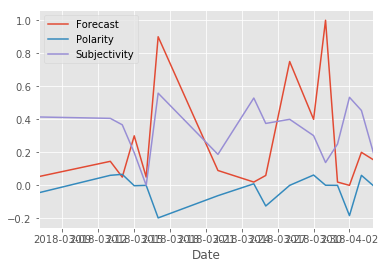

In [130]:
q_df.plot()

In [131]:
q_df.corr()

,Forecast,Polarity,Subjectivity
Forecast,1.000000,-0.123299,0.006195
Polarity,-0.123299,1.000000,-0.342077
Subjectivity,0.006195,-0.342077,1.000000


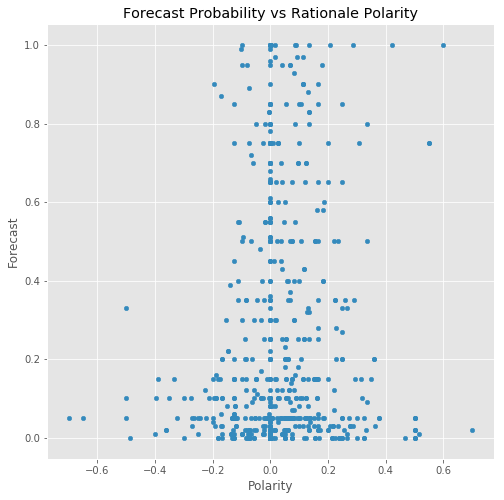

In [132]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
casts_df.plot(kind="scatter", y="Forecast", x="Polarity", ax=ax)
plt.title("Forecast Probability vs Rationale Polarity")
_path = os.path.join(DOC_PATH, "Forecaster Probability vs Rationale Polarity.png")
fig.savefig(_path)

In [133]:
_corr = casts_df[["Forecast", "Polarity"]].corr()
_corr

,Forecast,Polarity
Forecast,1.00000,0.07052
Polarity,0.07052,1.00000


In [134]:
_corr.loc["Forecast"]["Polarity"]

0.070519855464271086

In [135]:
def forecast_polarity_corr(_casts_df):
    _ifps = _casts_df.Question_ID.unique()
    corr_dict = {ifp: casts_df[casts_df.Question_ID == ifp][["Forecast", "Polarity"]].corr()
                 for ifp in _ifps}
    corr_ser = pd.Series({ifp: corr_dict[ifp].loc["Forecast"]["Polarity"]
                          for ifp in _ifps})
    return corr_ser

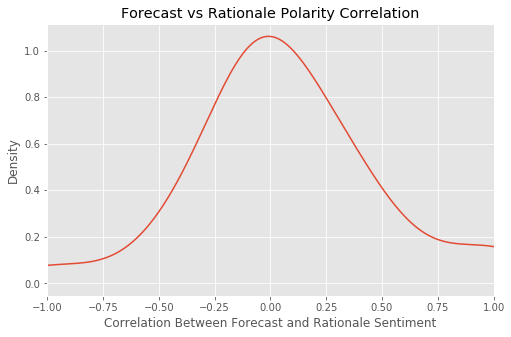

In [136]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
forecast_vs_polarity_ser = forecast_polarity_corr(casts_df)
forecast_vs_polarity_ser.plot(kind="density", xlim=(-1, 1), ax=ax)
plt.title("Forecast vs Rationale Polarity Correlation");
_path = os.path.join(DOC_PATH, "Forecaster Probability vs Rationale Correlation.png")
ax.set_xlabel("Correlation Between Forecast and Rationale Sentiment")
fig.savefig(_path)

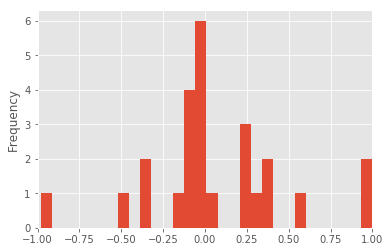

In [137]:
forecast_vs_polarity_ser.plot(kind="hist", xlim=(-1, 1), bins=30)

In [141]:
forecast_vs_polarity_ser.sort_values(ascending=False)

249    1.000000
259    0.991241
219    0.557267
198    0.390542
232    0.344560
197    0.333695
202    0.270426
214    0.236312
179    0.213389
215    0.057748
258    0.005721
200   -0.013678
201   -0.021668
196   -0.033914
199   -0.041904
229   -0.055757
241   -0.060106
213   -0.070525
203   -0.090689
254   -0.097866
211   -0.145075
248   -0.335891
210   -0.367695
245   -0.453921
251   -0.981874
257         NaN
dtype: float64

In [142]:
casts_df[casts_df.Question_ID==259].head()

,Forecast,Forecaster,Question_ID,Rationale,Update_DTG,Date,Polarity,Subjectivity
610,0.00,81015b8dec674104886e263766fafcbf9bfa5e63,259,"The Macedonian prime minister, Zoran Zaev, cla...",2018-04-04T20:15:53.464Z,2018-04-04,-0.125,0.125
617,0.01,0b4cc2230cba572ddd1aeadbd6a29e71319a1793,259,Greece won’t accept “Upper Macedonia” and Mace...,2018-04-04T20:00:55.094Z,2018-04-04,0.000,0.000
631,0.02,1671c9aff754c9fa5ccf38d2e68c9581d4a62598,259,If they even started now it would take a whole...,2018-04-04T19:01:13.411Z,2018-04-04,0.200,0.400
